This is a script for double deep learning agent with multiple choice of deep learning mechanisms(such as dueling, LSTM, and so on), . I created this agent because it can work 

with many environments(discrete or continuous), reward systems and input types(RAM or Image).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, LSTM
from keras.models import Sequential, load_model, save_model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import gym

In [2]:
# Creating a buffer for storing experience and sampling from it.
class ReplayBuff(object):

    def __init__(self, mem_size, batch_size, input_shape, action_n, discrete=True):

        self.memory_size = mem_size
        self.memory_counter = 0
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.discrete = discrete
        # State ,new state, reward and terminal memories.
        self.state_memory = np.zeros((self.memory_size, *input_shape))
        self.new_state_memory = np.zeros((self.memory_size, *input_shape))
        self.reward_memory = np.zeros(self.memory_size)
        self.done_memory = np.zeros(self.memory_size, dtype=np.float32)    
        # Data type is different between continuous and discrete action spaces.
        if self.discrete:
            data_type = np.int8
        else:
            data_type = np.float32 
        self.action_memory = np.zeros((self.memory_size, action_n), dtype=data_type)

    # Creating a function of ReplayBuff for storing informations of states.
    def store_transition(self, state, action, reward, new_state, done):

        index = self.memory_counter % self.memory_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.done_memory[index] = 1 - int(done)

        if self.discrete:
            action_one_hot = np.zeros(self.action_memory.shape[1])
            action_one_hot[action] = 1
            self.action_memory[index] = action_one_hot
        else:
            self.action_memory[index] = action
        self.memory_counter += 1

    # Creating a function of ReplayBuff for sampling informations of states from memory.
    def sample_buff(self):

        max_memory = min(self.memory_counter, self.memory_size)
        batch = np.random.choice(max_memory, self.batch_size, replace=False)
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.done_memory[batch]

        return states, actions, rewards, new_states, terminal

# Agent's dense deep learning model creating function for inputs as image.
def build_dq_learning_dense(learning_r, action_number, input_dims, add_cnn, first_dense_units, 
                            second_dense_units, first_conv_units, second_conv_units, third_conv_units, clip_value=1.0):
    
    model = Sequential()
    if add_cnn:

        model.add(Conv2D(first_conv_units, 3, padding='same', input_shape=(*input_dims, )))
        model.add(Activation('relu'))
        model.add(Conv2D(first_conv_units, 3, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D())


        model.add(Conv2D(second_conv_units, 3, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(second_conv_units, 3, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D())    


        model.add(Conv2D(third_conv_units, 3, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(third_conv_units, 3, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D())

        model.add(Flatten())


    model.add(Dense(first_dense_units, activation='relu'))

    model.add(Dense(second_dense_units, activation='relu'))


    model.add(Dense(action_number))

    model.compile(optimizer=Adam(learning_rate=learning_r), loss='mean_squared_error', clipvalue=clip_value)

    return model

# Agent's LSTM deep learning model creating function for inputs both as image or as RAM.
def build_dq_learning_LSTM(learning_r, action_number, input_dims, first_lstm_units, second_lstm_units, clip_value=1.0,
                           add_cnn=False, first_conv_units=None, second_conv_units=None, third_conv_units = None):
    
    model = Sequential()
    if add_cnn:

        model.add(Conv2D(first_conv_units, 3, padding='same', activation='relu', input_shape=(*input_dims, )))
        model.add(Conv2D(first_conv_units, 3, padding='same', activation='relu'))
        model.add(MaxPooling2D())

        model.add(Conv2D(second_conv_units, 3, padding='same', activation='relu'))
        model.add(Conv2D(second_conv_units, 3, padding='same', activation='relu'))
        model.add(MaxPooling2D())   

        model.add(Conv2D(third_conv_units, 3, padding='same', activation='relu'))
        model.add(Conv2D(third_conv_units, 3, padding='same', activation='relu'))
        model.add(MaxPooling2D())

        model.add(Flatten())

    model.add(LSTM(first_lstm_units, activation='relu', recurrent_activation='sigmoid', return_sequences=True))

    model.add(LSTM(second_lstm_units, activation='relu', recurrent_activation='sigmoid'))

    model.add(Dense(action_number))

    model.compile(opt = Adam(learning_rate=learning_r), loss='mean_squared_error', clipvalue=clip_value)

# Agent's dueling deep learning model creating class for inputs both as image or as RAM.
class DuelingDQLearning(tf.keras.Model):

    def __init__(self, first_dense_units, second_dense_units, action_n, add_cnn=False,
                 first_conv_units=None, second_conv_units=None, third_conv_units=None):
        super(DuelingDQLearning, self).__init__()

        self.add_cnn = add_cnn
        self.first_dense = Dense(first_dense_units, activation='relu')
        self.second_dense = Dense(second_dense_units, activation='relu')
        self.V = Dense(1)
        self.A = Dense(action_n)

        if add_cnn:
            self.first_conv = Conv2D(first_conv_units, 3, padding='same', activation='relu')
            self.second_conv = Conv2D(second_conv_units, 3, padding='same', activation='relu')
            self.third_conv = Conv2D(third_conv_units, 3, padding='same', activation='relu')

    # Function for predicting Q values with two streams.
    def call(self, input_data):

        if not self.add_cnn:
            x = self.first_dense(input_data)
            x = self.second_dense(x)
            V = self.V(x)
            A = self.A(x)

            Q = V + (A - tf.reduce_mean(A, axis=1, keepdims=True))

            return Q
        else:

            x = self.first_conv(input_data)
            x = MaxPooling2D()(x)
            x = self.second_conv(x)
            x = MaxPooling2D()(x)
            x = self.third_conv(x)
            x = MaxPooling2D()(x)
            x = Flatten()(x)

            x = self.first_dense(x)
            x = self.second_dense(x)
            V = self.V(x)
            A = self.A(x)

            Q = V + (A - tf.reduce_mean(A, axis=1, keepdims=True))

            return Q
            
    # Function for predicting advantage values.
    def advantage(self, state):

        if not self.add_cnn:

            x = self.first_dense(state)
            x = self.second_dense(x)
            A = self.A(x)

            return A
        else:

            x = self.first_conv(state)
            x = MaxPooling2D()(x)
            x = self.second_conv(x)
            x = MaxPooling2D()(x)
            x = self.third_conv(x)
            x = MaxPooling2D()(x)
            x = Flatten()(x)

            x = self.first_dense(x)
            x = self.second_dense(x)            
            A = self.A(x)

            return A

# Interface function for different types of deep learning types.
def build_dq_learning(learning_r=0.0003, action_number=None, input_dims=None, first_dense_units=256, 
                    second_dense_units=128, first_conv_units=32, second_conv_units=64, third_conv_units=128, 
                    type='DENSE', clip_value=1.0, first_lstm_units=256, second_lstm_units=128, add_cnn=False):

    if type.upper() == 'DENSE':
        return build_dq_learning_dense(learning_r, action_number, input_dims, add_cnn, first_dense_units,
                                        second_dense_units, first_conv_units, second_conv_units, third_conv_units,
                                        clip_value=clip_value)
    elif type.upper() == 'DUELING':
        return DuelingDQLearning(first_dense_units, second_dense_units, action_number, clip_value, add_cnn=add_cnn,
                                first_conv_units=first_conv_units, second_conv_units=second_conv_units,
                                third_conv_units=third_conv_units)

    elif type.upper() == 'LSTM':
        return build_dq_learning_LSTM(learning_r=learning_r, action_number=action_number, input_dims=input_dims, 
                                        add_cnn=add_cnn,first_lstm_units=first_lstm_units, second_lstm_units=second_lstm_units, 
                                        first_conv_units=first_conv_units , second_conv_units=second_conv_units, 
                                        third_conv_units=third_conv_units, clip_value=clip_value)

# Creating a Reinforcement Agent class.
class DDDQAgent(object):

    def __init__(self, learning_rate, discount, action_n, epsilon, batch_size,
                input_dims, epsilon_decay, epsilon_min, memory_size=1000000, replace=100,
                file_name = 'ddq_model.h5', dl_type = 'dueling', clip_value=1.0, discrete=True):

        self.action_space = [i for i in range(action_n)]
        self.action_n = action_n
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.replace = replace
        self.model_file = file_name
        self.dl_type = dl_type

        self.memory = ReplayBuff(memory_size, batch_size, input_dims, action_n, discrete=discrete)

        self.q_eval = build_dq_learning(learning_rate, action_n, input_dims, 
                                        256, 128, type=dl_type)
        self.q_target = build_dq_learning(learning_rate, action_n, input_dims, 
                                        256, 128, type=dl_type)
        
        if dl_type.lower() == 'dueling':

            opt = Adam(learning_rate=learning_rate, clipvalue=clip_value)
            self.q_eval.compile(optimizer=opt, loss='mse')
            self.q_target.compile(optimizer=opt, loss='mse')

    # Interface function for storing.
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Creating a function for agent to choose actions.
    def choose_action(self, state):
        state = state[np.newaxis, :]
        random_n = np.random.random()
        if random_n < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            if self.dl_type.lower() == 'dueling':
                actions = self.q_eval.advantage(state)
            else:
                actions = self.q_eval.predict(state)
                
            action = np.argmax(actions)
        return action

    # Function for updating target network.
    def update_target_dq_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())

    # Function for training Agent's model.
    def dq_learn(self):
        
        if self.memory.memory_counter > self.memory.batch_size:

            if self.memory.memory_counter % self.replace == 0:
                self.update_target_dq_parameters()

            state, actions, reward, new_state, done = self.memory.sample_buff()

            if self.memory.discrete:
                
                action_values = np.array(self.action_space, dtype=np.int8)
                action_decoded = np.dot(actions, action_values)
            else:
                action_decoded = actions

            q_next = self.q_target.predict(new_state)
            target = self.q_eval.predict(state)
            q_eval = self.q_eval.predict(new_state)

            max_actions = np.argmax(q_eval, axis=1).astype(int)

            q_target = np.copy(target)


            batch_index = np.arange(self.memory.batch_size, dtype=np.int32)

            q_target[batch_index, action_decoded] = reward + self.discount * q_next[batch_index, max_actions] * done

            his = self.q_eval.fit(state, q_target, verbose=0)

    # Function for decreasing exploring factor, also has a dictinory input for increasing epsilon to wanted values in wanted episodes. 
    def adjust_epsilon(self, epsion_reset_dict, episode_number):
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

        if str(episode_number) in epsion_reset_dict.keys():
            self.epsilon = epsion_reset_dict[str(episode_number)]

    # Function for saving the deep learning model.
    def save_ddqmodel(self):
        if self.dl_type != 'dueling':
            self.q_eval.save(self.model_file)
        else:
            self.q_eval.save(self.model_file, save_format='tf')
            
    # Function for loading the deep learning model.
    def load_ddqmodel(self):
        if self.dl_type != 'dueling':
            self.q_eval = load_model(self.model_file)
        else:
            self.q_eval = load_model(self.model_file, load_format='tf')

        if self.epsilon <= self.epsilon_min:
            self.update_target_dq_parameters()


NOTE: Agent class is completed, code below is an example of Dueling type of Agent with discrete action space and RAM inputs that can be created with this class.

In [3]:
env = gym.make('LunarLander-v2')

ddq_agent = DDDQAgent(learning_rate=0.0003, discount=0.995, action_n=env.action_space.n, epsilon=1.0,
                     batch_size=32, input_dims=env.observation_space.shape, epsilon_decay=0.998, 
                     epsilon_min=0.01, memory_size=1000000, replace=64)

2022-05-14 13:13:25.558609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
GAMECOUNT = 800

ddq_scores = []
eps_history = []
score_avgs_50 = []
reset_epsilon_dict = {'100' : 1, '300': 0.8, '500':1}

for i in range(GAMECOUNT):
    done=False
    score = 0
    observation = env.reset()
    while not done:
        env.render()
        action = ddq_agent.choose_action(observation)
        new_observation, reward, done, info = env.step(action)
        score += reward
        ddq_agent.remember(observation, action, reward, new_observation, done)
        observation = new_observation
        ddq_agent.dq_learn()
        ddq_agent.adjust_epsilon(reset_epsilon_dict, i)
    
    score_avg_50 = None

    if i >= 51:
        score_avg_50 = sum(ddq_scores[i-50:i]) / 50
        score_avgs_50.append(score_avg_50)
    
    if score_avg_50 != None:
        print(f'Episode: {i}, Score: {score}, Epsilon: {ddq_agent.epsilon}, Score Avarage 50: {score_avg_50}')
    else:
        print(f'Episode: {i}, Score: {score}, Epsilon: {ddq_agent.epsilon}, Score Avarage 50: Not Available')


    ddq_scores.append(score)
    eps_history.append(ddq_agent.epsilon)
env.close()

x_vector = [i for i in range(GAMECOUNT)]

Episode: 0, Score: -155.83929790012587, Epsilon: 0.8120378896731923, Score Avarage 50: Not Available
Episode: 1, Score: -397.08108653814134, Epsilon: 0.6594055342648917, Score Avarage 50: Not Available
Episode: 2, Score: -136.41542398260916, Epsilon: 0.5484820084336942, Score Avarage 50: Not Available
Episode: 3, Score: -161.35671641985869, Epsilon: 0.4489691650726603, Score Avarage 50: Not Available
Episode: 4, Score: -141.60808858730132, Epsilon: 0.3069158799260717, Score Avarage 50: Not Available
Episode: 5, Score: -70.80058574909569, Epsilon: 0.2300473871314662, Score Avarage 50: Not Available
Episode: 6, Score: -305.53531854253674, Epsilon: 0.1366967029182184, Score Avarage 50: Not Available
Episode: 7, Score: -562.8827506798539, Epsilon: 0.10022866347613922, Score Avarage 50: Not Available
Episode: 8, Score: -456.68046492920354, Epsilon: 0.07512593403091018, Score Avarage 50: Not Available
Episode: 9, Score: -156.24792832112269, Epsilon: 0.03332649550772031, Score Avarage 50: Not

/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_23159/3775233127.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  score_graph.plot(x_vector, ddq_scores, 'b', label='Score', color='green', alpha=0.5)
/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_23159/3775233127.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  epsilon_graph.plot(x_vector, eps_history, 'b', label='Epsilon', color='red')
/var/folders/vy/55zch8zs5qd1y2j8sysjjrk80000gn/T/ipykernel_23159/3775233127.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


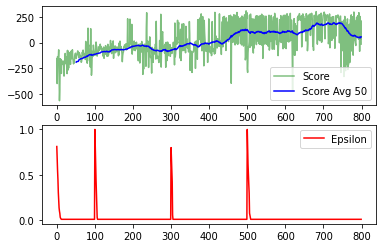

In [13]:
fig = plt.figure()

score_graph = fig.add_subplot(2, 1, 1)
epsilon_graph = fig.add_subplot(2, 1, 2)



score_graph.plot(x_vector, ddq_scores, 'b', label='Score', color='green', alpha=0.5)
score_graph.plot(x_vector[51:], score_avgs_50, 'b', label='Score Avg 50')
score_graph.legend(loc='best')

epsilon_graph.plot(x_vector, eps_history, 'b', label='Epsilon', color='red')
epsilon_graph.legend(loc='best')

fig.show()